<a href="https://colab.research.google.com/github/YuHsiH/freecodecamp_ML/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
'''
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
'''

import tensorflow as tf
import pandas as pd
from tensorflow import keras
#!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-04-16 09:28:28--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.06s   

2024-04-16 09:28:28 (5.27 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-04-16 09:28:28--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [3]:
train_dataset=pd.read_csv('train-data.tsv',sep='\t',names=['class','text'])
train_dataset

,class,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [4]:
valid_dataset=pd.read_csv('valid-data.tsv',sep='\t',names=['class','text'])
valid_dataset

,class,text
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


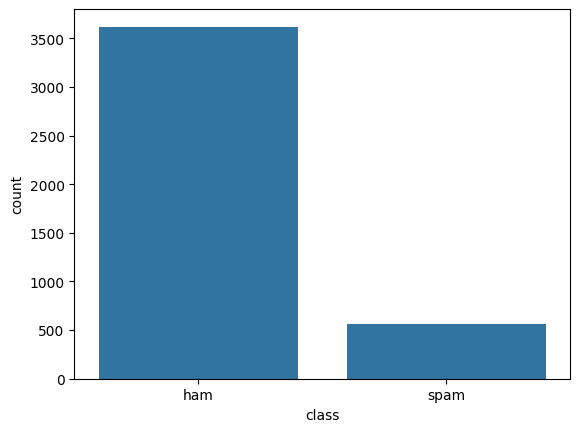

In [5]:
import seaborn as sns
sns.countplot(x=train_dataset['class'])
plt.show()

In [6]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in train_dataset['text']])/len(train_dataset['text']))
print(avg_words_len)

16


In [7]:
# Finding Total no of unique words in corpus
s = set()
for sent in train_dataset['text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

11330


covert the spam and ham to 0 and 1 for training and validation dataset

In [8]:
train_dataset['class']=(train_dataset['class']=='ham').astype(int)
valid_dataset['class']=(valid_dataset['class']=='ham').astype(int)

`tf.data.Dataset.from_tensor_slices`

This function is used to create a TensorFlow dataset from a list of tensors. It takes a single argument, which can be:

A list of tensors (e.g., [tensor1, tensor2, ...])

A tuple containing multiple tensors (e.g., (tensor1, tensor2, ...))

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_dataset["text"].values, train_dataset["class"].values))
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid_dataset["text"].values, valid_dataset["class"].values))
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

encoder = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
encoder.adapt(train_ds.map(lambda text, label: text)) #return text only

In [34]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U48')

In [12]:
#Create a model

model= tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), # remove return_sequence to be compatible with dense layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 16, 64)            523584    
                                                                 
 bidirectional (Bidirection  (None, 16, 128)           66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [13]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


131/131 [==============================] - 35s 113ms/step - loss: 0.2409 - accuracy: 0.9273 - val_loss: 0.0846 - val_accuracy: 0.9688
Epoch 2/10
131/131 [==============================] - 8s 61ms/step - loss: 0.0360 - accuracy: 0.9899 - val_loss: 0.0601 - val_accuracy: 0.9781
Epoch 3/10
131/131 [==============================] - 9s 68ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.1056 - val_accuracy: 0.9781
Epoch 4/10
131/131 [==============================] - 18s 135ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.1039 - val_accuracy: 0.9771
Epoch 5/10
131/131 [==============================] - 14s 106ms/step - loss: 5.5304e-04 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 0.9802
Epoch 6/10
131/131 [==============================] - 9s 67ms/step - loss: 4.1426e-04 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9781
Epoch 7/10
131/131 [==============================] - 9s 67ms/step - loss: 3.5666e-04 - accuracy: 1.0000 - val_loss: 0.1211 - val_accuracy:

In [15]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.25290953776420794)

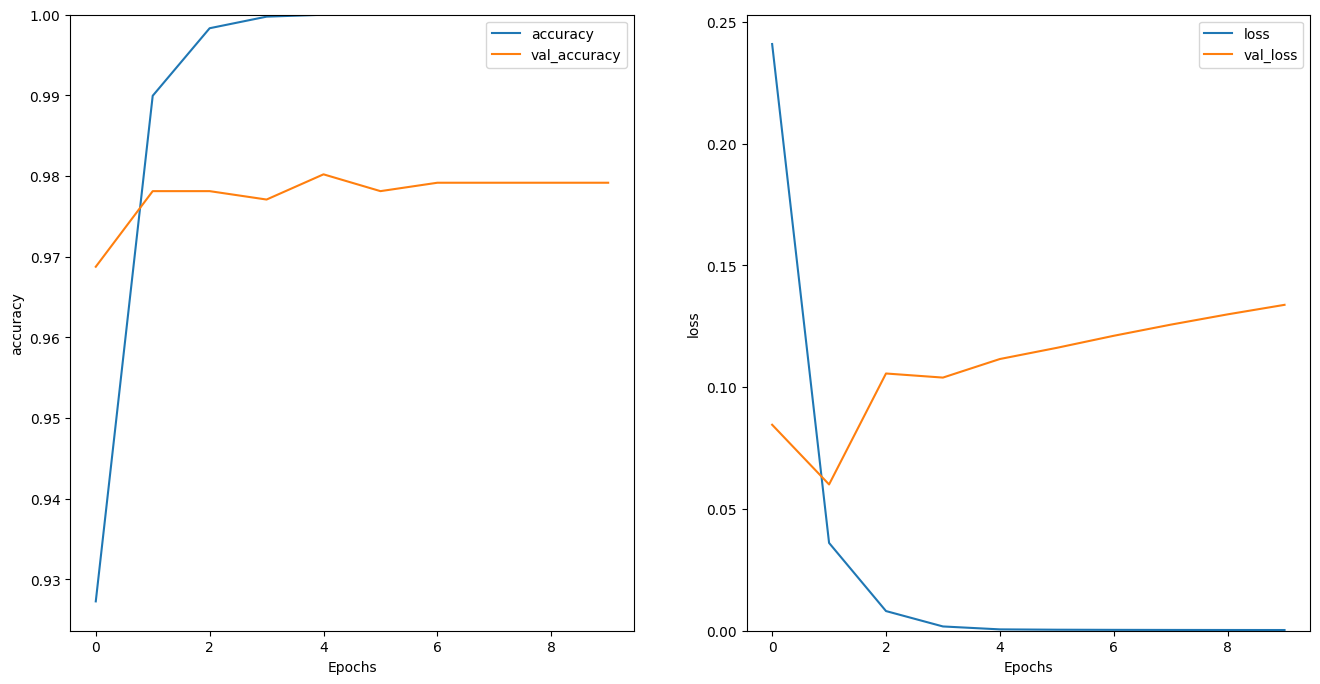

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [43]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps=model.predict([pred_text])
    #print(ps)
    p = ps[0][0]
    return [p, "ham" if p >0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 59ms/step
[0.99999875, 'ham']


In [38]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 45ms/step
[[0.99999875]]
1/1 [==============================] - 0s 44ms/step
[[0.00243233]]
1/1 [==============================] - 0s 52ms/step
[[0.99999964]]
1/1 [==============================] - 0s 52ms/step
[[2.8658606e-06]]
1/1 [==============================] - 0s 50ms/step
[[9.477443e-06]]
1/1 [==============================] - 0s 44ms/step
[[0.9999998]]
1/1 [==============================] - 0s 52ms/step
[[0.9999997]]
You passed the challenge. Great job!
